# DL Project notebook 

__Group 6__
* Tanushri Jajoo
* Zena Zheng
* Jessica Bormann



The main aim of this project is to replicate the stock price prediction model named as CNN-BiLSTM-ECA proposed by Chen, Fang, Liang, Sha, Li, Yi, Zhou, and Song (2021). The secondary aim of this project is to improve them model and apply different data sets.

Part 1: Replication
* 1.1 The Model
* 1.2 The Data
    + 1.2.1 Loading Data
    + 1.2.2 Data Cleaning
    + 1.2.3 Normalization
    + 1.2.4 Train & Test Split
* 1.3 Model Fitting
* 1.4 Evaluation
    + 1.4.1 Predictions
    + 1.4.2 Transform to Original Scale
    + 1.4.3 Calculate Error
    + 1.4.4 Plotting


Part 2: Improvement & Application
* 2.1 China Petrol Data
    + 2.1.1 Loading Data
    + 2.1.2 Data Cleaning
    + 2.1.3 Normalization
    + 2.1.4 Fitting
    + 2.1.5 Evaluation
* 2.2 Changing the Model
* 2.3 The Crypto Data
    + 2.3.1 Loading Data
    + 2.3.2 Data Cleaning
    + 2.3.3 Adding Features
* 2.4 Improving the Model
    + Test 1
    + Test 2
    + Test 3
    + Test 4
* 2.5 Evaluation
    + 2.5.1 Calculate Error
    + 2.5.2 Plotting

In [1]:
import os          
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
import matplotlib.pyplot as pyplot

#from attention_utils import get_activations
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.regularizers import l2,l1
import  pandas as pd
import  numpy as np

# Setting up
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# preparing for CNN
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# evaluation
import math

# crypto data
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tabulate import tabulate
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Part 1: Replication

## 1.1 The model
* time series prediction model named as CNN-BiLSTM-ECA (Chen, Fang, Liang, Sha, Li, Yi, Zhou, & Song, 2021)
* CNN → extract the deep features
* Bidirectional Long Short-term Memory (BiLSTM) model → learns the temporal features from the new time series data constructed by the deep feature vectors
* Effective Channel Attention (ECA) → extracts more important features effective and less complex (fast and “light”)
    + kernel size k is set to 3 (Wang et al., 2020)
* Dense model → performs the prediction task
* predict the next day’s stock closing price


In [2]:
def  CNN_BiLSTM_ECA_model(time_steps, nr_features):
    """
    input:
        time_steps: 
        nr_features: the dimensions of the input data
    
    """
    
    # instantiate a Keras tensor
    input_layer = layers.Input(shape = (time_steps, nr_features))
    
    ## hidden layers
    # Convolutional Neural Network
    conv1 = layers.Conv1D(filters = 64, kernel_size = 1, activation = "relu", padding = "same")(input_layer)
    
    # Bidirectional LSTM
    lstm = layers.Bidirectional(layers.LSTM(64, return_sequences = True, activation = "relu"))(conv1) 
    
    # Attention Module ECA
    gap = layers.GlobalAveragePooling1D()(lstm)
    lam = tf.keras.layers.Reshape((128, 1))(gap) # Lambda layer
    cov1 = layers.Conv1D(filters = 1, kernel_size = 3, strides = 1, padding = "same", activation = "sigmoid")(lam)
    perm = layers.Permute((2, 1))(cov1)
    mult = layers.multiply([lstm, perm])
    
    # Dense model
    flat = layers.Flatten()(mult)
    den1 = layers.Dense(128, activation = "relu")(flat) 
    den2 = layers.Dense(32, activation = "relu")(den1)
    den3 = layers.Dense(1, activation = "relu")(den2)
    
    model = keras.Model(inputs = [input_layer], outputs = den3)
    
    return model
    

## 1.2 The Data

1) Shanghai Composite Index (SSE Index for short, stock symbol: 000001) collected from December 20, 1990, to November 23, 2020 (7304 groups)

2) China Unicom (stock symbol: 600050) - collected from October 9, 2002, to March 17, 2021 (4340 groups)

3) CSI 300 (stock symbol: 399300) - collected from January 7, 2002, to March 17, 2021 (4567 groups)

Each stock data (7304 in total) includes: 
* Dat - date
* Close - the closing price
* High - the highest price
* Low - the lowest price
* Open - the opening price
* Pre-close - previous day’s closing price
* change - ups and downs (difference between yesterday's & today's stock price)
* Pct_chg - percentage of change
* Vol - the total number of shares that are actually traded (not used as predictor)
* Amount - amount of currency exchange in that day (not used as predictor)


### 1.2.1 Loading data

In [3]:
stock_data_SSE = pd.read_csv("stock_shanghai.csv")
stock_data_SSE.head()

,date,close,high,low,open,pre_close,change,pct_chg,vol,amount
0,1990/12/20,104.39,104.39,99.98,104.30,99.98,4.41,4.4109,197,84000.0
1,1990/12/21,109.13,109.13,103.73,109.07,104.39,4.74,4.5407,28,16000.0
2,1990/12/24,114.55,114.55,109.13,113.57,109.13,5.42,4.9666,32,31000.0
3,1990/12/25,120.25,120.25,114.55,120.09,114.55,5.70,4.9760,15,6000.0
4,1990/12/26,125.27,125.27,120.25,125.27,120.25,5.02,4.1746,100,53000.0


In [4]:
stock_data_UNICOM = pd.read_csv("stock_china_unicom.csv")
stock_data_UNICOM.head()

,date,close,high,low,open,pre_close,change,pct_chg
0,2002/10/9,2.87,3.15,2.86,3.05,2.30,0.57,24.7826
1,2002/10/10,2.83,2.89,2.79,2.83,2.87,-0.04,-1.3937
2,2002/10/11,2.94,2.96,2.83,2.85,2.83,0.11,3.8869
3,2002/10/14,3.01,3.02,2.94,2.96,2.94,0.07,2.3810
4,2002/10/15,2.98,3.01,2.96,3.01,3.01,-0.03,-0.9967


In [5]:
stock_data_CSI300 = pd.read_csv("stock_csi300.csv")
stock_data_CSI300.head()

,date,close,high,low,open,pre_close,change,pct_chg
0,2002/1/7,1302.08,1302.08,1302.08,1302.08,1316.46,-14.38,-1.0923
1,2002/1/8,1292.71,1292.71,1292.71,1292.71,1302.08,-9.37,-0.7196
2,2002/1/9,1272.65,1272.65,1272.65,1272.65,1292.71,-20.06,-1.5518
3,2002/1/10,1281.26,1281.26,1281.26,1281.26,1272.65,8.61,0.6765
4,2002/1/11,1249.81,1249.81,1249.81,1249.81,1281.26,-31.45,-2.4546


### 1.2.2 Data Cleaning
Dropping irrelevant columns - how do we know that vol & was not used as feature is it mentioned in the article?

In [7]:
stock_data_SSE = stock_data_SSE.drop(['date','vol','amount'], axis = 1)
print(stock_data_SSE.shape)

(7304, 7)


In [8]:
stock_data_UNICOM = stock_data_UNICOM.drop(["date"], axis = 1)
print(stock_data_UNICOM.shape)

(4340, 7)


In [9]:
stock_data_CSI300 = stock_data_CSI300.drop(['date'], axis = 1)
print(stock_data_CSI300.shape)

(4657, 7)


In [10]:
def remove_missing_values(crypto_df):
    
    # Identifying if there are missing values 
    is_NaN = np.isnan(crypto_df)
    row_has_NaN = is_NaN.any(axis = 1)
    rows_with_NaN = crypto_df[row_has_NaN]

    # removing missing values
    return crypto_df[-row_has_NaN]

In [11]:
stock_data_SSE = remove_missing_values(stock_data_SSE)

In [12]:
stock_data_UNICOM = remove_missing_values(stock_data_UNICOM)

In [13]:
stock_data_CSI300 = remove_missing_values(stock_data_CSI300)

### 1.2.3 Normalization

The data we received is already done with interpolation and sorting.
data normalization is employed to deal with the problem of inconsistency in the magnitude of the data → Value of data is converted to [0, 1] with transformation function: (x - min) / (max - min) (Chen, Fang, Liang, Sha, Li, Yi, Zhou, & Song, 2021)

Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1. (How to normalize and standardize time series data in Python, 2019)

In [14]:
def normalize(stock_data):
    """
    input:
        stock_data:
        col_nr:
    output:
        normalized_value: 
        max_min:
        
    """
    col_nr = stock_data.shape[1]
    
    # prepare data for normalization
    stock_data = np.array(stock_data)
    values = stock_data.reshape((len(stock_data), col_nr))

    # Maximum and minimum values for prediction value revers back
    max_min = np.full([col_nr, 2], None)
    for i in range(0, stock_data.shape[1]):
        max_min[i,0] = stock_data[:,i].max()
        max_min[i,1] = stock_data[:,i].min()


    # train the normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)

    # normalize the dataset 
    normalized_value = scaler.transform(values)
        
    return normalized_value, max_min

In [15]:
normalized_SSE, max_min_SSE = normalize(stock_data_SSE)
normalized_UNICOM, max_min_UNICOM = normalize(stock_data_UNICOM)
normalized_CSI300, max_min_CSI300 = normalize(stock_data_CSI300)

### 1.2.4 Train & test split

Prepare the data with time step

(How to develop Convolutional neural network models for time series forecasting, 2020)

In [16]:
# Makes the format of the data according to the time step
def split_sequence(sequence, n_steps):
    """
    input:
        sequence:
        n_steps:
    output:
        X:
        y:
    """
    
    X, y = [], []
    for i in range(len(sequence)- n_steps - 1):
    # find the end of this pattern
        end_ix = i + n_steps
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [17]:
def train_test_split(normalized_value, n_steps, predictor_col, train_perc = .85):
    """
    input:
        normalized_value: from normalize()
        n_steps: time steps
        predictor_col: column index of predictor 
        train_perc: percentage of training data
    output:
        x_train: training data
        y_train: observed predictor values
        x_test: validation data
        y_test: observed predictor values
    """
    
    ## create data of step of 10
    predictors = split_sequence(normalized_value,  n_steps) [0]
    y_label = split_sequence(normalized_value[:,predictor_col].reshape(len(normalized_value), 1), n_steps) [1]

    ## split the data
    split = round(train_perc * len(normalized_value))

    # create the training and testing data
    x_train = predictors[:split, :]
    y_train = y_label[:split]

    x_test = predictors[split:, :]
    y_test = y_label[split:]
    
    return x_train, y_train, x_test, y_test

In [18]:
# Hyperparameters
nr_col = 7
time_steps = 10
predictor_col = 0

In [19]:
x_train_SSE, y_train_SSE, x_test_SSE, y_test_SSE = train_test_split(normalized_SSE, 
                                                                    time_steps, 
                                                                    predictor_col)

x_train_UNICOM, y_train_UNICOM, x_test_UNICOM, y_test_UNICOM = train_test_split(normalized_UNICOM, 
                                                                                time_steps, 
                                                                                predictor_col)

x_train_CSI300, y_train_CSI300, x_test_CSI300, y_test_CSI300 = train_test_split(normalized_CSI300, 
                                                                                time_steps, 
                                                                                predictor_col)
print("SSE:")
print(x_train_SSE.shape, y_train_SSE.shape)
print(x_test_SSE.shape, y_test_SSE.shape)
print("")
print("UNICOM:")
print(x_train_UNICOM.shape, y_train_UNICOM.shape)
print(x_test_UNICOM.shape, y_test_UNICOM.shape)
print("")
print("CSI300:")
print(x_train_CSI300.shape, y_train_CSI300.shape)
print(x_test_CSI300.shape, y_test_CSI300.shape)

SSE:
(6208, 10, 7) (6208, 1)
(1085, 10, 7) (1085, 1)

UNICOM:
(3689, 10, 7) (3689, 1)
(640, 10, 7) (640, 1)

CSI300:
(3958, 10, 7) (3958, 1)
(688, 10, 7) (688, 1)


## 1.3 Model Fitting

In [20]:
stock_prediction = CNN_BiLSTM_ECA_model(time_steps, nr_col)
stock_prediction.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 7)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 10, 64)       512         ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 10, 128)      66048       ['conv1d[0][0]']                 
                                                                                                  
 global_average_pooling1d (Glob  (None, 128)         0           ['bidirectional[0][0]']          
 alAveragePooling1D)                                                                          

2021-12-24 11:55:01.619225: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
stock_prediction.compile(
    optimizer = "adam",
    loss = "MSE",
    metrics = ["MSE"]
)

In [22]:
history_SSE = stock_prediction.fit(
    x_train_SSE,
    y_train_SSE,
    validation_data = (x_test_SSE, y_test_SSE),
    epochs = 200,
    verbose = 1,
    batch_size = 256
)

Epoch 1/200
25/25 [==============================] - 3s 30ms/step - loss: 0.0139 - MSE: 0.0139 - val_loss: 0.0012 - val_MSE: 0.0012
Epoch 2/200
25/25 [==============================] - 0s 18ms/step - loss: 4.1282e-04 - MSE: 4.1282e-04 - val_loss: 1.5009e-04 - val_MSE: 1.5009e-04
Epoch 3/200
25/25 [==============================] - 0s 18ms/step - loss: 2.6857e-04 - MSE: 2.6857e-04 - val_loss: 1.7236e-04 - val_MSE: 1.7236e-04
Epoch 4/200
25/25 [==============================] - 0s 18ms/step - loss: 2.6591e-04 - MSE: 2.6591e-04 - val_loss: 1.5211e-04 - val_MSE: 1.5211e-04
Epoch 5/200
25/25 [==============================] - 0s 18ms/step - loss: 2.4199e-04 - MSE: 2.4199e-04 - val_loss: 1.1828e-04 - val_MSE: 1.1828e-04
Epoch 6/200
25/25 [==============================] - 0s 19ms/step - loss: 2.3846e-04 - MSE: 2.3846e-04 - val_loss: 1.1232e-04 - val_MSE: 1.1232e-04
Epoch 7/200
25/25 [==============================] - 0s 20ms/step - loss: 2.0650e-04 - MSE: 2.0650e-04 - val_loss: 1.0541e-04 - 

In [23]:
history_UNICOM = stock_prediction.fit(
    x_train_UNICOM,
    y_train_UNICOM,
    validation_data = (x_test_UNICOM, y_test_UNICOM),
    epochs = 200,
    verbose = 1,
    batch_size = 256
)

Epoch 1/200
15/15 [==============================] - 0s 26ms/step - loss: 0.0023 - MSE: 0.0023 - val_loss: 0.0010 - val_MSE: 0.0010
Epoch 2/200
15/15 [==============================] - 0s 28ms/step - loss: 5.2922e-04 - MSE: 5.2922e-04 - val_loss: 1.4013e-04 - val_MSE: 1.4013e-04
Epoch 3/200
15/15 [==============================] - 0s 23ms/step - loss: 2.7287e-04 - MSE: 2.7287e-04 - val_loss: 1.9438e-04 - val_MSE: 1.9438e-04
Epoch 4/200
15/15 [==============================] - 0s 27ms/step - loss: 2.6812e-04 - MSE: 2.6812e-04 - val_loss: 1.1377e-04 - val_MSE: 1.1377e-04
Epoch 5/200
15/15 [==============================] - 0s 30ms/step - loss: 2.3408e-04 - MSE: 2.3408e-04 - val_loss: 1.7997e-04 - val_MSE: 1.7997e-04
Epoch 6/200
15/15 [==============================] - 0s 26ms/step - loss: 2.4340e-04 - MSE: 2.4340e-04 - val_loss: 1.2467e-04 - val_MSE: 1.2467e-04
Epoch 7/200
15/15 [==============================] - 0s 28ms/step - loss: 2.2455e-04 - MSE: 2.2455e-04 - val_loss: 1.1828e-04 - 

In [24]:
history_CSI300 = stock_prediction.fit(
    x_train_CSI300,
    y_train_CSI300,
    validation_data = (x_test_CSI300, y_test_CSI300),
    epochs = 200,
    verbose = 1,
    batch_size = 256
)

Epoch 1/200
16/16 [==============================] - 0s 30ms/step - loss: 0.0014 - MSE: 0.0014 - val_loss: 5.9928e-04 - val_MSE: 5.9928e-04
Epoch 2/200
16/16 [==============================] - 0s 28ms/step - loss: 1.8541e-04 - MSE: 1.8541e-04 - val_loss: 2.0157e-04 - val_MSE: 2.0157e-04
Epoch 3/200
16/16 [==============================] - 0s 27ms/step - loss: 1.2073e-04 - MSE: 1.2073e-04 - val_loss: 1.3029e-04 - val_MSE: 1.3029e-04
Epoch 4/200
16/16 [==============================] - 0s 27ms/step - loss: 1.0829e-04 - MSE: 1.0829e-04 - val_loss: 1.3848e-04 - val_MSE: 1.3848e-04
Epoch 5/200
16/16 [==============================] - 0s 29ms/step - loss: 1.1117e-04 - MSE: 1.1117e-04 - val_loss: 1.3010e-04 - val_MSE: 1.3010e-04
Epoch 6/200
16/16 [==============================] - 0s 28ms/step - loss: 1.1109e-04 - MSE: 1.1109e-04 - val_loss: 1.8202e-04 - val_MSE: 1.8202e-04
Epoch 7/200
16/16 [==============================] - 0s 29ms/step - loss: 1.1612e-04 - MSE: 1.1612e-04 - val_loss: 1.600

## 1.4 Evaluation

### 1.4.1 Predictions

In [25]:
predictions_SSE = stock_prediction.predict(x_test_SSE)
predictions_UNICOM = stock_prediction.predict(x_test_UNICOM)
predictions_CSI300 = stock_prediction.predict(x_test_CSI300)

### 1.4.2 Transform to original scale

In [26]:
def transform_to_original_value(max_min, predictions, y_test):
    
    # inverse back
    max_value =  max_min[0][0]
    min_value =  max_min[0][1]

    # transform back
    pre_inverse = predictions * (max_value - min_value) + min_value
    test_inverse = y_test * (max_value - min_value) + min_value
    
    return pre_inverse, test_inverse

In [27]:
pre_inverse_SSE, test_inverse_SSE = transform_to_original_value(max_min_SSE, predictions_SSE, y_test_SSE)
pre_inverse_UNICOM, test_inverse_UNICOM = transform_to_original_value(max_min_UNICOM, predictions_UNICOM, 
                                                                   y_test_UNICOM)
pre_inverse_CSI300, test_inverse_CSI300 = transform_to_original_value(max_min_CSI300, predictions_CSI300, 
                                                                      y_test_CSI300)

### 1.4.2 Calculate error

Code for Table by Matalka (2021)

In [28]:
def calculate_error(test_inverse, pre_inverse):
    
    # MSE RMSE MAE for inversed value
    MSE = mean_squared_error(test_inverse, pre_inverse)
    RMSE = math.sqrt(MSE)
    MAE = mean_absolute_error(test_inverse, pre_inverse)

    return MSE, RMSE, MAE

In [29]:
error_SSE = calculate_error(pre_inverse_SSE, test_inverse_SSE)
error_UNICOM = calculate_error(pre_inverse_UNICOM, test_inverse_UNICOM)
error_CSI300 = calculate_error(pre_inverse_CSI300, test_inverse_CSI300)

print("SSE:", error_SSE)
print("UNICOM", error_UNICOM)
print("CSI300", error_CSI300)

SSE: (294688.2670706082, 542.8519752847992, 540.9322441168636)
UNICOM (0.2017522814250973, 0.4491684332464797, 0.4325278900116681)
CSI300 (3639.355076846736, 60.32706753064279, 43.004005210415116)


In [30]:
table = {"Data": ["SSE", "UNICOM", "CSI300"], 
         "MSE": [error_SSE[0], error_UNICOM[0], error_CSI300[0]], 
         "RMSE": [error_SSE[1], error_UNICOM[1], error_CSI300[1]],
         "MAE": [error_SSE[2], error_UNICOM[2], error_CSI300[2]]}

print(tabulate(table, headers = "keys"))

Data              MSE        RMSE         MAE
------  -------------  ----------  ----------
SSE     294688         542.852     540.932
UNICOM       0.201752    0.449168    0.432528
CSI300    3639.36       60.3271     43.004


### 1.4.3 Plotting

In [31]:
def plot_loss_curve(history_df, y_bottom = 0, y_top = 0.001):
    
    history_df.loc[:, ['loss', 'val_loss']].plot()
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(y_bottom, y_top)
    plt.legend(['train', 'test'])#, loc = 'upper left')
    plt.show()

In [32]:
history_frame_SSE = pd.DataFrame(history_SSE.history)
history_frame_UNICOM = pd.DataFrame(history_UNICOM.history)
history_frame_CSI300 = pd.DataFrame(history_CSI300.history)

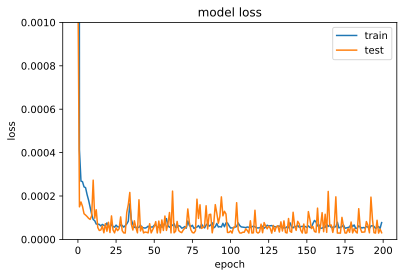

In [33]:
plot_loss_curve(history_frame_SSE)

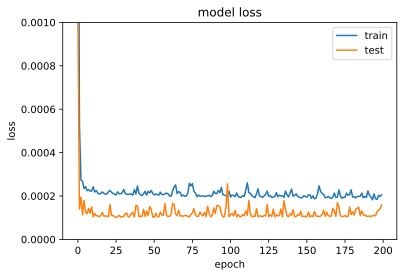

In [34]:
plot_loss_curve(history_frame_UNICOM)

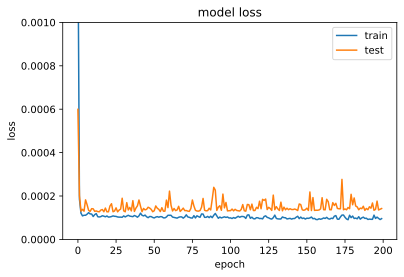

In [35]:
plot_loss_curve(history_frame_CSI300)

# Part 2: Improvement & Application

## 2.1 China Petrol Data

The replicated model is tested on another data set, China Petrol, which we got from the internet (Stock price of PetrolChina, n.d.).

* __Close__: Closing price of the time interval (in USD).
* __High__: Highest price reached during time interval (in USD).
* __Low__: Lowest price reached during time interval (in USD).
* __Open__: Opening price of the time interval (in USD).
* __pre-close__: previous day’s closing price
* __change__: ups and downs (difference between yesterday's & today's stock price)
* __Pct_chg__: percentage of change
* __pct_chg__: ups and downs (difference between yesterday's & today's stock price)
* __Volume__: Quantity of asset bought or sold, displayed in base currency USD.
* __amount__: amount of currency exchange in that day (not used as predictor)
* __total market capitalization__: -
* __Circulation market value__: -
* __Turnover Rate__: -



### 2.1.1 Loading Data

In [36]:
stock_data_petrol = pd.read_csv("PetrolChina.csv")
stock_data_petrol

,date,close,high,low,open,pre_close,change,pct_chg,vol,amount,total market capitalization,Circulation market value,Turnover Rate
0,2007/11/5,43.96,48.62,41.70,48.60,16.70,27.26,163.2335,1.547499e+09,6.999139e+10,8.050000e+12,1.320000e+11,51.5833
1,2007/11/6,39.99,42.40,39.80,41.40,43.96,-3.97,-9.0309,3.429778e+08,1.400025e+10,7.320000e+12,1.200000e+11,11.4326
2,2007/11/7,40.43,40.73,38.28,39.70,39.99,0.44,1.1003,2.166189e+08,8.575267e+09,7.400000e+12,1.210000e+11,7.2206
3,2007/11/8,38.19,39.75,38.00,39.20,40.43,-2.24,-5.5404,1.400510e+08,5.447045e+09,6.990000e+12,1.150000e+11,4.6684
4,2007/11/9,38.18,38.39,36.66,37.85,38.19,-0.01,-0.0262,1.432266e+08,5.379485e+09,6.990000e+12,1.150000e+11,4.7742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431,2021/12/10,4.97,5.06,4.93,5.06,5.08,-0.11,-2.1654,1.592311e+08,7.937675e+08,9.100000e+11,8.050000e+11,0.0983
3432,2021/12/13,4.96,5.01,4.94,4.96,4.97,-0.01,-0.2012,1.158116e+08,5.750724e+08,9.080000e+11,8.030000e+11,0.0715
3433,2021/12/14,4.86,4.94,4.82,4.94,4.96,-0.10,-2.0161,1.584250e+08,7.700813e+08,8.890000e+11,7.870000e+11,0.0978
3434,2021/12/15,4.83,4.85,4.79,4.83,4.86,-0.03,-0.6173,9.435763e+07,4.551528e+08,8.840000e+11,7.820000e+11,0.0583


### 2.1.2 Data Cleaning

In [37]:
stock_data_petrol_df = stock_data_petrol.drop(['date','vol','amount', 'total market capitalization', 
                                            'Circulation market value', 'Turnover Rate'], axis = 1)

stock_data_petrol_df.head()

,close,high,low,open,pre_close,change,pct_chg
0,43.96,48.62,41.70,48.60,16.70,27.26,163.2335
1,39.99,42.40,39.80,41.40,43.96,-3.97,-9.0309
2,40.43,40.73,38.28,39.70,39.99,0.44,1.1003
3,38.19,39.75,38.00,39.20,40.43,-2.24,-5.5404
4,38.18,38.39,36.66,37.85,38.19,-0.01,-0.0262


In [38]:
stock_data_petrol_clean = remove_missing_values(stock_data_petrol_df)
stock_data_petrol.isnull().values.any()

True

### 2.1.3 Normalization

In [39]:
normalized_petrol, max_min_petrol = normalize(stock_data_petrol_clean)
x_train_petrol, y_train_petrol, x_test_petrol, y_test_petrol = train_test_split(normalized_petrol,
                                                                                time_steps, predictor_col)

### 2.1.4 Fitting

In [40]:
history_petrol = stock_prediction.fit(
    x_train_petrol,
    y_train_petrol,
    validation_data = (x_test_petrol, y_test_petrol),
    epochs = 200,
    verbose = 0,
    batch_size = 256
)

### 2.1.5 Evaluation

In [41]:
predictions_petrol = stock_prediction.predict(x_test_petrol)
pre_inverse_petrol, test_inverse_petrol = transform_to_original_value(max_min_petrol, predictions_petrol,
                                                                      y_test_petrol)

error_petrol = calculate_error(pre_inverse_petrol, test_inverse_petrol)
print("MSE: ", error_petrol[0], "RMSE: ", error_petrol[1], "MAE: ", error_petrol[2])

MSE:  0.3139401723353628 RMSE:  0.560303642978843 MAE:  0.4958522779187909


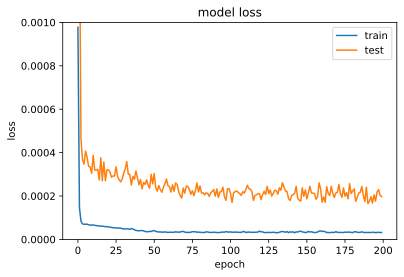

In [42]:
history_frame_petrol = pd.DataFrame(history_petrol.history)
plot_loss_curve(history_frame_petrol, 0, 0.001)

In [43]:
def plot_true_vs_predicted_price(pre_inverse, test_inverse, predictor_str, title, ylab):
    
    pre_inverse = pd.DataFrame(pre_inverse)
    pre_inverse.columns = [predictor_str]

    test_inverse = pd.DataFrame(test_inverse)
    test_inverse.columns = [predictor_str]

    plt.plot(pre_inverse.index.values, pre_inverse[predictor_str],
             test_inverse.index.values, test_inverse[predictor_str])

    plt.title(title)
    plt.xlabel("Time value (day)")
    plt.ylabel(ylab)
    plt.legend(['Prediction', 'True Price'])
    
    plt.show()

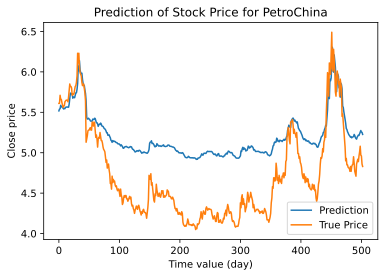

In [44]:
plot_true_vs_predicted_price(pre_inverse_petrol, test_inverse_petrol, "close", 
                             "Prediction of Stock Price for PetroChina", "Close price")

From the plot above we can see that the predictions are more accurate in the beginning and in the end than in the middle, which gives an indication that the model is underfitting.

## 2.2 Changing the model


To improve the model we add early stopping and a layer with 30% Droput. We also tried BatchNormslization but this only increased the error so we decided not to include it. Furthermore we tried a different DV (VWAP) and time stamp of 2.

In [45]:
def  new_model(time_steps, nr_features):
    
    # instantiate a Keras tensor
    input_layer = layers.Input(shape = (time_steps, nr_features))
    
    ## hidden layers
    # Convolutional Neural Network
    conv1 = layers.Conv1D(filters = 64, kernel_size = 1, activation = "relu", padding = "same")(input_layer)
    
    # Bidirectional LSTM
    lstm = layers.Bidirectional(layers.LSTM(64, return_sequences = True, activation = "relu"))(conv1) 
    
    # Attention Module ECA
    gap = layers.GlobalAveragePooling1D()(lstm)
    lam = tf.keras.layers.Reshape((128, 1))(gap) # Lambda layer
    cov1 = layers.Conv1D(filters = 1, kernel_size = 3, strides = 1, padding = "same", activation = "sigmoid")(lam)
    perm = layers.Permute((2, 1))(cov1)
    mult = layers.multiply([lstm, perm])
    
    drop = layers.Dropout(rate = 0.3)(mult)
    
    # Dense model
    flat = layers.Flatten()(drop)
    den1 = layers.Dense(128, activation = "relu")(flat) 
    den2 = layers.Dense(32, activation = "relu")(den1)
    den3 = layers.Dense(1, activation = "relu")(den2)
    
    model = keras.Model(inputs = [input_layer], outputs = den3)
    
    return model
    

In [46]:
early_stopping = EarlyStopping(
    min_delta = 0.001, 
    patience = 20, 
    restore_best_weights = True,
)

## 2.3 The Crypto Data

The Data is from a Kaggle competition (G-research crypto forecasting, n.d.).

* __timestamp__: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
* __Asset_ID__: The asset ID corresponding to one of the crytocurrencies (e.g. Asset_ID = 1 for Bitcoin). The mapping from Asset_ID to crypto asset is contained in asset_details.csv.
* __Count__: Total number of trades in the time interval (last minute).
* __Open__: Opening price of the time interval (in USD).
* __High__: Highest price reached during time interval (in USD).
* __Low__: Lowest price reached during time interval (in USD).
* __Close__: Closing price of the time interval (in USD).
* __Volume__: Quantity of asset bought or sold, displayed in base currency USD.
* __VWAP__: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
* __Target__: Residual log-returns for the asset over a 15 minute horizon.


To prepare the data we followed some of the steps in the Tutorial to the G-research crypto competition (2021).

### 2.3.1 Loading data

In [47]:
crypto_df = pd.read_csv("train.csv")
crypto_df

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.800000,13666.110000,13850.176000,3.155006e+01,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.920000,25.874000,25.877000,1.210873e+02,25.891363,-0.008264
...,...,...,...,...,...,...,...,...,...,...
24236801,1632182400,9,775.0,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,NaN
24236802,1632182400,10,34.0,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN


In [48]:
asset_details = pd.read_csv("asset_details.csv")
asset_details.sort_values("Asset_ID", axis = 0)

,Asset_ID,Weight,Asset_Name
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
0,2,2.397895,Bitcoin Cash
10,3,4.406719,Cardano
13,4,3.555348,Dogecoin
3,5,1.386294,EOS.IO
5,6,5.894403,Ethereum
4,7,2.079442,Ethereum Classic
11,8,1.098612,IOTA
6,9,2.397895,Litecoin


In [50]:
# select crypto assets
btc = crypto_df[crypto_df["Asset_ID"] == 1]
btc_cash = crypto_df[crypto_df["Asset_ID"] == 2]
dogecoin = crypto_df[crypto_df["Asset_ID"] == 4]

### 2.3.2 Data Cleaning

In [51]:
def data_preparation(crypto_df, cols_to_remove):
    """
    input:
        crypto_df: a pd.Dataframe 
        cols_to_remove: a list of srings, columns to remove
    output:
        crypto_df_perDay: clean data frame where each row is one day, unimportant columns & missing
        values are removed
    """
    
    # add datetime
    crypto_df["datetime"] = pd.to_datetime(crypto_df["timestamp"], unit = "s")
    
    # set timestamp as index
    crypto_df = crypto_df.set_index("timestamp")

    # remove unnecessary columns
    crypto_df_datetime = crypto_df.drop(cols_to_remove, axis = 1)
    
    # save first and last date
    start_date = str(crypto_df.index[0].astype('datetime64[s]'))
    end_date = str(crypto_df.index[-1].astype('datetime64[s]'))

    # average per day
    crypto_df_reduced = crypto_df_datetime.groupby([crypto_df_datetime["datetime"].dt.year, 
                                                   crypto_df_datetime["datetime"].dt.month,
                                                   crypto_df_datetime["datetime"].dt.day]).mean()
    
    # set index as datetime
    date_idx = pd.date_range(start = start_date, end = end_date, periods = crypto_df_reduced.shape[0])
    crypto_df_perDay = crypto_df_reduced.set_index(date_idx)
    
    # remove missing values
    crypto_df_clean = remove_missing_values(crypto_df_perDay)
    
    return crypto_df_clean

In [52]:
to_remove = ["Asset_ID", "Target"] 

btc_df = data_preparation(btc, to_remove)
btc_cash_df = data_preparation(btc_cash, to_remove)
dogecoin_df = data_preparation(dogecoin, to_remove)

dogecoin_df

/var/folders/g8/8kzwyk0n1114n3hx8pk3yx1w0000gn/T/ipykernel_2316/3319690570.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crypto_df["datetime"] = pd.to_datetime(crypto_df["timestamp"], unit = "s")


,Count,Open,High,Low,Close,Volume,VWAP
2019-04-12 14:34:00.000000000,13.702913,0.002809,0.002811,0.002808,0.002809,3.626732e+05,0.002809
2019-04-13 14:33:01.276595744,13.826281,0.002820,0.002822,0.002818,0.002820,5.630255e+05,0.002820
2019-04-14 14:32:02.553191489,11.317734,0.002821,0.002822,0.002820,0.002821,2.299484e+05,0.002821
2019-04-15 14:31:03.829787234,12.506137,0.002812,0.002813,0.002810,0.002812,2.912292e+05,0.002812
2019-04-16 14:30:05.106382978,8.595681,0.002746,0.002747,0.002745,0.002746,1.609311e+05,0.002746
...,...,...,...,...,...,...,...
2021-09-17 00:03:54.893617024,612.307639,0.244492,0.244815,0.244173,0.244494,1.883383e+06,0.244489
2021-09-18 00:02:56.170212768,219.473611,0.242301,0.242511,0.242112,0.242305,6.692646e+05,0.242300
2021-09-19 00:01:57.446808512,197.063194,0.238007,0.238213,0.237820,0.238005,5.840126e+05,0.238000
2021-09-20 00:00:58.723404256,671.687500,0.216287,0.216657,0.215907,0.216276,2.204334e+06,0.216269


### 2.3.3 Adding features

* __Pre-close__ - previous day’s closing price
* __Pct_chg__ - ups and downs (difference between yesterday's & today's stock price)

In [53]:
def pre_close_feature(df_input):
    """
    output: data frame with added feature Pre-close - previous day’s closing price 
    """
    
    df = df_input.copy()
    
    # create a copy of column Close
    df_copy = df.iloc[:,4]

    # transform series to array
    pre_close_array = df_copy.array

    # remove last element
    pre_close_last = pre_close_array[:-1]

    # append 0 at the beginning
    pre_close_beg = pre_close_last.insert(0, 0)

    # add feature to the data frame
    df["pre_close"] = pre_close_beg
    
    return df

In [54]:
def pct_change_feature(df_input):
    """
    output: data frame with added feature Pct_chg - ups and downs 
            (difference between yesterday's & today's stock price)
    """
    
    df = df_input.copy()
    
    # todays - yesterdays stock price
    pct_change = df.iloc[:,4] - df.iloc[:,-1]
    
    # transform series to array
    pct_change_array = pct_change.array
    
    # add feature to the data frame
    df["pct_change"] = pct_change_array
    
    return df

## 2.4 Improving the Model

We fit the model with different specifications.

__Test 1__
* DV: Closing price
* features: Count, Open, High, Low, Volume, VWAP
* time steps = 10

__Test 2__
* DV: Closing price
* features: Count, Open, High, Low, Volume, VWAP
* time steps = 2

__Test 3__
* DV: Closing price
* features: Count, Open, High, Low, Volume, VWAP, Pre-close, Pct_chg
* time steps = 2

__Test 4__
* DV: VWAP
* features: Count, Open, High, Low, Volume, Pre-close, Pct_chg, Closing
* time steps = 2

__Test 5__

Only for Dogecoin data
* DV: VWAP
* features: Open, High, Low, Closing
* time steps = 2

### Test 1

In [55]:
to_remove = ["Asset_ID", "Target"] 

btc_df = data_preparation(btc, to_remove)
btc_cash_df = data_preparation(btc_cash, to_remove)
dogecoin_df = data_preparation(dogecoin, to_remove)
dogecoin_df.head()

/var/folders/g8/8kzwyk0n1114n3hx8pk3yx1w0000gn/T/ipykernel_2316/3319690570.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crypto_df["datetime"] = pd.to_datetime(crypto_df["timestamp"], unit = "s")


,Count,Open,High,Low,Close,Volume,VWAP
2019-04-12 14:34:00.000000000,13.702913,0.002809,0.002811,0.002808,0.002809,362673.204769,0.002809
2019-04-13 14:33:01.276595744,13.826281,0.002820,0.002822,0.002818,0.002820,563025.450035,0.002820
2019-04-14 14:32:02.553191489,11.317734,0.002821,0.002822,0.002820,0.002821,229948.432735,0.002821
2019-04-15 14:31:03.829787234,12.506137,0.002812,0.002813,0.002810,0.002812,291229.209952,0.002812
2019-04-16 14:30:05.106382978,8.595681,0.002746,0.002747,0.002745,0.002746,160931.118857,0.002746


In [56]:
# Normalization
normalized_btc, max_min_btc = normalize(btc_df)
normalized_btc_cash, max_min_btc_cash = normalize(btc_cash_df)
normalized_dogecoin, max_min_dogecoin = normalize(dogecoin_df)

nr_col = 7
time_steps = 10
predictor_col = 4
nr_epochs = 200

improved_model = new_model(time_steps, nr_col)

improved_model.compile(
    optimizer = "adam",
    loss = "MSE",
    metrics = ["MSE"]
)

x_train_btc, y_train_btc, x_test_btc, y_test_btc = train_test_split(normalized_btc, time_steps, predictor_col)
x_train_btc_cash, y_train_btc_cash, x_test_btc_cash, y_test_btc_cash = train_test_split(normalized_btc_cash, 
                                                                                        time_steps, predictor_col)
x_train_dogecoin, y_train_dogecoin, x_test_dogecoin, y_test_dogecoin = train_test_split(normalized_dogecoin, 
                                                                                        time_steps, predictor_col)


history_btc = improved_model.fit(
    x_train_btc, y_train_btc,
    validation_data = (x_test_btc, y_test_btc),
    epochs = nr_epochs, verbose = 0, batch_size = 256,
    callbacks = [early_stopping]
)

history_btc_cash = improved_model.fit(
    x_train_btc_cash, y_train_btc_cash,
    validation_data = (x_test_btc_cash, y_test_btc_cash),
    epochs = nr_epochs, verbose = 0, batch_size = 256,
    callbacks = [early_stopping]
)

history_dogecoin = improved_model.fit(
    x_train_dogecoin, y_train_dogecoin,
    validation_data = (x_test_dogecoin, y_test_dogecoin),
    epochs = nr_epochs, verbose = 0, batch_size = 256,
    callbacks = [early_stopping]
)

predictions_btc = improved_model.predict(x_test_btc)
predictions_btc_cash = improved_model.predict(x_test_btc_cash)
predictions_dogecoin = improved_model.predict(x_test_dogecoin)

# Transform to Original Scale
pre_inverse_btc, test_inverse_btc = transform_to_original_value(max_min_btc, predictions_btc, y_test_btc)
pre_inverse_btc_cash, test_inverse_btc_cash = transform_to_original_value(max_min_btc_cash, predictions_btc_cash, 
                                                                          y_test_btc_cash)
pre_inverse_dogecoin, test_inverse_dogecoin = transform_to_original_value(max_min_dogecoin, predictions_dogecoin, 
                                                                          y_test_dogecoin)

### Test 2

In [57]:
# same data frame as Test 1 so same normalized values

time_steps = 2

improved_model_2 = new_model(time_steps, nr_col)

improved_model_2.compile(
    optimizer = "adam",
    loss = "MSE",
    metrics = ["MSE"]
)

x_train_btc2, y_train_btc2, x_test_btc2, y_test_btc2 = train_test_split(normalized_btc, time_steps, predictor_col)
x_train_btc_cash2, y_train_btc_cash2, x_test_btc_cash2, y_test_btc_cash2 = train_test_split(normalized_btc_cash, 
                                                                                            time_steps, 
                                                                                            predictor_col)
x_train_dogecoin2, y_train_dogecoin2, x_test_dogecoin2, y_test_dogecoin2 = train_test_split(normalized_dogecoin,
                                                                                            time_steps, 
                                                                                            predictor_col)


history_btc2 = improved_model_2.fit(
    x_train_btc2, y_train_btc2,
    validation_data = (x_test_btc2, y_test_btc2),
    epochs = nr_epochs, verbose = 0, batch_size = 256,
    callbacks = [early_stopping]
)

history_btc_cash2 = improved_model_2.fit(
    x_train_btc_cash2, y_train_btc_cash2,
    validation_data = (x_test_btc_cash2, y_test_btc_cash2),
    epochs = nr_epochs, verbose = 0, batch_size = 256,
    callbacks = [early_stopping]
)

history_dogecoin2 = improved_model_2.fit(
    x_train_dogecoin2, y_train_dogecoin2,
    validation_data = (x_test_dogecoin2, y_test_dogecoin2),
    epochs = nr_epochs, verbose = 0, batch_size = 256,
    callbacks = [early_stopping]
)

predictions_btc2 = improved_model_2.predict(x_test_btc2)
predictions_btc_cash2 = improved_model_2.predict(x_test_btc_cash2)
predictions_dogecoin2 = improved_model_2.predict(x_test_dogecoin2)

# Transform to Original Scale
pre_inverse_btc2, test_inverse_btc2 = transform_to_original_value(max_min_btc, predictions_btc2, y_test_btc2)
pre_inverse_btc_cash2, test_inverse_btc_cash2 = transform_to_original_value(max_min_btc_cash, predictions_btc_cash2, 
                                                                            y_test_btc_cash2)
pre_inverse_dogecoin2, test_inverse_dogecoin2 = transform_to_original_value(max_min_dogecoin, predictions_dogecoin2, 
                                                                            y_test_dogecoin2)

### Test 3

In [58]:
# adding features
btc_df1 = pre_close_feature(btc_df)
btc_df2 = pct_change_feature(btc_df1)

btc_cash_df1 = pre_close_feature(btc_cash_df)
btc_cash_df2 = pct_change_feature(btc_cash_df1)

dogecoin_df1 = pre_close_feature(dogecoin_df)
dogecoin_df2 = pct_change_feature(dogecoin_df1)
dogecoin_df2.head()

,Count,Open,High,Low,Close,Volume,VWAP,pre_close,pct_change
2019-04-12 14:34:00.000000000,13.702913,0.002809,0.002811,0.002808,0.002809,362673.204769,0.002809,0.000000,2.809087e-03
2019-04-13 14:33:01.276595744,13.826281,0.002820,0.002822,0.002818,0.002820,563025.450035,0.002820,0.002809,1.085397e-05
2019-04-14 14:32:02.553191489,11.317734,0.002821,0.002822,0.002820,0.002821,229948.432735,0.002821,0.002820,7.655454e-07
2019-04-15 14:31:03.829787234,12.506137,0.002812,0.002813,0.002810,0.002812,291229.209952,0.002812,0.002821,-8.833250e-06
2019-04-16 14:30:05.106382978,8.595681,0.002746,0.002747,0.002745,0.002746,160931.118857,0.002746,0.002812,-6.587737e-05


In [59]:
# Normalization
normalized_btc2, max_min_btc2 = normalize(btc_df2)
normalized_btc_cash2, max_min_btc_cash2 = normalize(btc_cash_df2)
normalized_dogecoin2, max_min_dogecoin2 = normalize(dogecoin_df2)

nr_col = 9

improved_model_3 = new_model(time_steps, nr_col)

improved_model_3.compile(
    optimizer = "adam",
    loss = "MSE",
    metrics = ["MSE"]
)


# normalized_btc2 --> added features
x_train_btc3, y_train_btc3, x_test_btc3, y_test_btc3 = train_test_split(normalized_btc2, time_steps, predictor_col)
x_train_btc_cash3, y_train_btc_cash3, x_test_btc_cash3, y_test_btc_cash3 = train_test_split(normalized_btc_cash2,
                                                                                            time_steps, 
                                                                                            predictor_col)
x_train_dogecoin3, y_train_dogecoin3, x_test_dogecoin3, y_test_dogecoin3 = train_test_split(normalized_dogecoin2, 
                                                                                            time_steps, 
                                                                                            predictor_col)

history_btc3 = improved_model_3.fit(
    x_train_btc3, y_train_btc3,
    validation_data = (x_test_btc3, y_test_btc3),
    epochs = nr_epochs, verbose = 0, batch_size = 256,
    callbacks = [early_stopping]
)

history_btc_cash3 = improved_model_3.fit(
    x_train_btc_cash3, y_train_btc_cash3,
    validation_data = (x_test_btc_cash3, y_test_btc_cash3),
    epochs = nr_epochs, verbose = 0, batch_size = 256,
    callbacks = [early_stopping]
)

history_dogecoin3 = improved_model_3.fit(
    x_train_dogecoin3, y_train_dogecoin3,
    validation_data = (x_test_dogecoin3, y_test_dogecoin3),
    epochs = nr_epochs, verbose = 0, batch_size = 256,
    callbacks = [early_stopping]
)

predictions_btc3 = improved_model_3.predict(x_test_btc3)
predictions_btc_cash3 = improved_model_3.predict(x_test_btc_cash3)
predictions_dogecoin3 = improved_model_3.predict(x_test_dogecoin3)

## Transform to Original Scale
pre_inverse_btc3, test_inverse_btc3 = transform_to_original_value(max_min_btc2, predictions_btc3, y_test_btc3)
pre_inverse_btc_cash3, test_inverse_btc_cash3 = transform_to_original_value(max_min_btc_cash2, 
                                                                            predictions_btc_cash3, y_test_btc_cash3)
pre_inverse_dogecoin3, test_inverse_dogecoin3 = transform_to_original_value(max_min_dogecoin2, 
                                                                            predictions_dogecoin3, y_test_dogecoin3)

### Test 4

In [60]:
# same data frame as Test 3 so same normalized values

predictor_col = 6

x_train_btc4, y_train_btc4, x_test_btc4, y_test_btc4 = train_test_split(normalized_btc2, time_steps, predictor_col)
x_train_btc_cash4, y_train_btc_cash4, x_test_btc_cash4, y_test_btc_cash4 = train_test_split(normalized_btc_cash2, 
                                                                                            time_steps,
                                                                                            predictor_col)
x_train_dogecoin4, y_train_dogecoin4, x_test_dogecoin4, y_test_dogecoin4 = train_test_split(normalized_dogecoin2, 
                                                                                            time_steps, 
                                                                                            predictor_col)

history_btc4 = improved_model_3.fit(
    x_train_btc4, y_train_btc4,
    validation_data = (x_test_btc4, y_test_btc4),
    epochs = nr_epochs, verbose = 0, batch_size = 256,
    callbacks = [early_stopping]
)

history_btc_cash4 = improved_model_3.fit(
    x_train_btc_cash4, y_train_btc_cash4,
    validation_data = (x_test_btc_cash4, y_test_btc_cash4),
    epochs = nr_epochs, verbose = 0, batch_size = 256,
    callbacks = [early_stopping]
)

history_dogecoin4 = improved_model_3.fit(
    x_train_dogecoin4, y_train_dogecoin4,
    validation_data = (x_test_dogecoin4, y_test_dogecoin4),
    epochs = nr_epochs, verbose = 0, batch_size = 256,
    callbacks = [early_stopping]
)

predictions_btc4 = improved_model_3.predict(x_test_btc4)
predictions_btc_cash4 = improved_model_3.predict(x_test_btc_cash4)
predictions_dogecoin4 = improved_model_3.predict(x_test_dogecoin4)

## Transform to Original Scale
pre_inverse_btc4, test_inverse_btc4 = transform_to_original_value(max_min_btc2, predictions_btc4, y_test_btc4)
pre_inverse_btc_cash4, test_inverse_btc_cash4 = transform_to_original_value(max_min_btc_cash2, 
                                                                            predictions_btc_cash4, y_test_btc_cash4)
pre_inverse_dogecoin4, test_inverse_dogecoin4 = transform_to_original_value(max_min_dogecoin2, 
                                                                            predictions_dogecoin4, y_test_dogecoin4)

### Test 5

In [61]:
to_remove = ["Asset_ID", "Target", "Count", "Volume"] 

dogecoin_df5 = data_preparation(dogecoin, to_remove)
dogecoin_df5.head()

/var/folders/g8/8kzwyk0n1114n3hx8pk3yx1w0000gn/T/ipykernel_2316/3319690570.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crypto_df["datetime"] = pd.to_datetime(crypto_df["timestamp"], unit = "s")


,Open,High,Low,Close,VWAP
2019-04-12 14:34:00.000000000,0.002809,0.002811,0.002808,0.002809,0.002809
2019-04-13 14:33:01.276595744,0.002820,0.002822,0.002818,0.002820,0.002820
2019-04-14 14:32:02.553191489,0.002821,0.002822,0.002820,0.002821,0.002821
2019-04-15 14:31:03.829787234,0.002812,0.002813,0.002810,0.002812,0.002812
2019-04-16 14:30:05.106382978,0.002746,0.002747,0.002745,0.002746,0.002746


In [62]:
normalized_dogecoin5, max_min_dogecoin5 = normalize(dogecoin_df5)
predictor_col = 4
nr_col = 5
x_train_dogecoin5, y_train_dogecoin5, x_test_dogecoin5, y_test_dogecoin5 = train_test_split(normalized_dogecoin5, 
                                                                                            time_steps, 
                                                                                            predictor_col)

improved_model_4 = new_model(time_steps, nr_col)

improved_model_4.compile(
    optimizer = "adam",
    loss = "MSE",
    metrics = ["MSE"]
)


history_dogecoin5 = improved_model_4.fit(
    x_train_dogecoin5, y_train_dogecoin5,
    validation_data = (x_test_dogecoin5, y_test_dogecoin5),
    epochs = nr_epochs, verbose = 0, batch_size = 256,
    callbacks = [early_stopping]
)
predictions_dogecoin5 = improved_model_4.predict(x_test_dogecoin5)
pre_inverse_dogecoin5, test_inverse_dogecoin5 = transform_to_original_value(max_min_dogecoin5, predictions_dogecoin5, 
                                                                  y_test_dogecoin5)


## 2.5 Evaluation

### 2.5.1 Calculate Error

In [63]:
# Test 1
error_btc = calculate_error(pre_inverse_btc, test_inverse_btc)
error_btc_cash = calculate_error(pre_inverse_btc_cash, test_inverse_btc_cash)
error_dogecoin = calculate_error(pre_inverse_dogecoin, test_inverse_dogecoin)

table = {"Crypto currency": ["Bitcoin Cash", "Bitcoin", "Dogecoin"], 
         "MSE": [error_btc_cash[0], error_btc[0], error_dogecoin[0]], 
         "RMSE": [error_btc_cash[1], error_btc[1], error_dogecoin[1]],
         "MAE": [error_btc_cash[2], error_btc[2], error_dogecoin[2]]}

print(tabulate(table, headers = "keys"))

Crypto currency          MSE      RMSE       MAE
-----------------  ---------  --------  --------
Bitcoin Cash         4813.64   69.3804   43.6666
Bitcoin            232201     481.873   389.894
Dogecoin           383060     618.918   457.922


In [64]:
# Test 2
error_btc2 = calculate_error(pre_inverse_btc2, test_inverse_btc2)
error_btc_cash2 = calculate_error(pre_inverse_btc_cash2, test_inverse_btc_cash2)
error_dogecoin2 = calculate_error(pre_inverse_dogecoin2, test_inverse_dogecoin2)

table2 = {"Crypto currency": ["Bitcoin Cash", "Bitcoin", "Dogecoin"], 
          "MSE": [error_btc_cash2[0], error_btc2[0], error_dogecoin2[0]], 
          "RMSE": [error_btc_cash2[1], error_btc2[1], error_dogecoin2[1]],
          "MAE": [error_btc_cash2[2], error_btc2[2], error_dogecoin2[2]]}

print(tabulate(table2, headers = "keys"))

Crypto currency          MSE      RMSE       MAE
-----------------  ---------  --------  --------
Bitcoin Cash         2033.88   45.0986   27.3002
Bitcoin            237130     486.96    368.876
Dogecoin           300377     548.067   395.679


In [65]:
# Test 3
error_btc3 = calculate_error(pre_inverse_btc3, test_inverse_btc3)
error_btc_cash3 = calculate_error(pre_inverse_btc_cash3, test_inverse_btc_cash3)
error_dogecoin3 = calculate_error(pre_inverse_dogecoin3, test_inverse_dogecoin3)

table3 = {"Crypto currency": ["Bitcoin Cash", "Bitcoin", "Dogecoin"], 
          "MSE": [error_btc_cash3[0], error_btc3[0], error_dogecoin3[0]], 
          "RMSE": [error_btc_cash3[1], error_btc3[1], error_dogecoin3[1]],
          "MAE": [error_btc_cash3[2], error_btc3[2], error_dogecoin3[2]]}

print(tabulate(table3, headers = "keys"))

Crypto currency          MSE      RMSE       MAE
-----------------  ---------  --------  --------
Bitcoin Cash         2557.54   50.5721   30.2707
Bitcoin            249247     499.247   414.926
Dogecoin           399110     631.751   475.07


In [66]:
# Test 4
error_btc4 = calculate_error(pre_inverse_btc4, test_inverse_btc4)
error_btc_cash4 = calculate_error(pre_inverse_btc_cash4, test_inverse_btc_cash4)
error_dogecoin4 = calculate_error(pre_inverse_dogecoin4, test_inverse_dogecoin4)

table4 = {"Crypto currency": ["Bitcoin Cash", "Bitcoin", "Dogecoin"], 
          "MSE": [error_btc_cash4[0], error_btc4[0], error_dogecoin4[0]], 
          "RMSE": [error_btc_cash4[1], error_btc4[1], error_dogecoin4[1]],
          "MAE": [error_btc_cash4[2], error_btc4[2], error_dogecoin4[2]]}

print(tabulate(table4, headers = "keys"))

Crypto currency          MSE      RMSE       MAE
-----------------  ---------  --------  --------
Bitcoin Cash         2312.39   48.0873   33.4597
Bitcoin            447180     668.715   573.797
Dogecoin           243836     493.798   315.353


In [67]:
# Test 5
error_dogecoin5 = calculate_error(pre_inverse_dogecoin5, test_inverse_dogecoin5)
print("MSE: ", error_dogecoin5[0], "RMSE: ", error_dogecoin5[1], "MAE: ", error_dogecoin5[2])

MSE:  0.0007020533936577855 RMSE:  0.02649629018669945 MAE:  0.01941150230292197


### 2.5.2 Plotting

Bitcoin cash has the lowest error with data & model specifications of Test 4.
Bitcoin has the lowest error with data & model specifications of Test 4.
Dogecoin has the lowest error with data & model specifications of Test 5.

In [68]:
history_frame_btc = pd.DataFrame(history_btc4.history)
history_frame_btc_cash = pd.DataFrame(history_btc_cash4.history)
history_frame_btc_dogecoin = pd.DataFrame(history_dogecoin5.history)

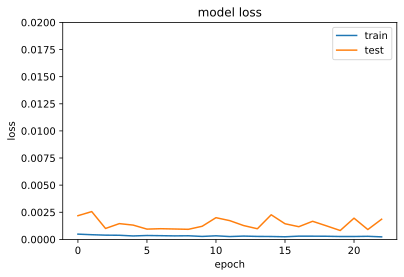

In [69]:
plot_loss_curve(history_frame_btc, 0, 0.02)

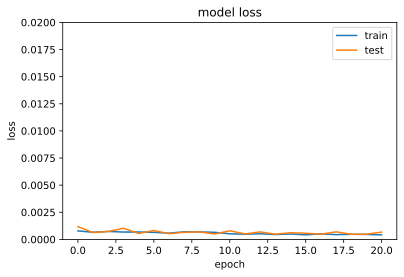

In [70]:
plot_loss_curve(history_frame_btc_cash, 0, 0.02)

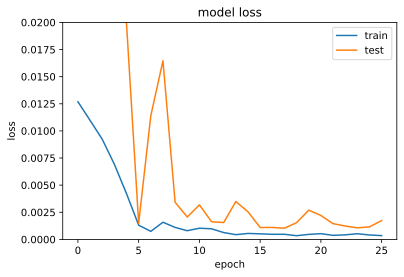

In [71]:
plot_loss_curve(history_frame_btc_dogecoin, 0, 0.02)

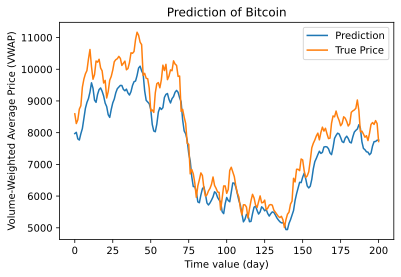

In [72]:
plot_true_vs_predicted_price(pre_inverse_btc4, test_inverse_btc4, "VWAP", "Prediction of Bitcoin", 
                             "Volume-Weighted Average Price (VWAP)") 

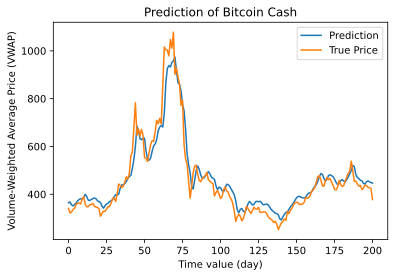

In [73]:
plot_true_vs_predicted_price(pre_inverse_btc_cash4, test_inverse_btc_cash4, "VWAP", "Prediction of Bitcoin Cash",
                             "Volume-Weighted Average Price (VWAP)")

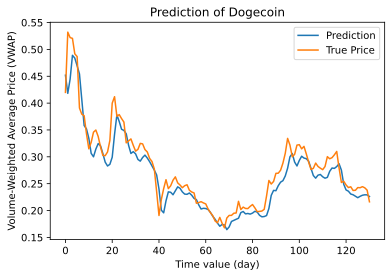

In [74]:
plot_true_vs_predicted_price(pre_inverse_dogecoin5, test_inverse_dogecoin5, "VWAP", "Prediction of Dogecoin", 
                             "Volume-Weighted Average Price (VWAP)")

__Conclusions__

* The current model can capture the general pattern of different stocks
* Model performance varies given different datasets
* Adjustment is needed with certain datasets
* Psychological features such as sentiment of news or social media should be considered for future research

# References

Chen, Y., Fang, R., Liang, T., Sha, Z., Li, S., Yi, Y., Zhou, W., & Song, H. (2021). Stock price forecast based on 
    CNN-bilstm-ECA model. Scientific Programming, 2021, 1-20. https://doi.org/10.1155/2021/2446543
    
G-research crypto forecasting. Kaggle. (n.d.). Kaggle: Your Machine Learning and Data Science Community. 
    https://www.kaggle.com/c/g-research-crypto-forecasting

How to develop Convolutional neural network models for time series forecasting. (2020,   August 27). Machine  Learning Mastery. https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
    
How to normalize and standardize time series data in Python. (2019, August 28). Machine Learning Mastery. 
    https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ 

Matalka, L. (2021, February 26). How to easily create tables in Python. towardsdatascience. https://towardsdatascience.com/how-to-easily-create-tables-in-python-2eaea447d8fd

Module: Tf.keras. (2021, November 5). TensorFlow. https://www.tensorflow.org/api_docs/python/tf/keras 
        
Tutorial to the G-research crypto competition. (2021, November 3). Kaggle: Your Machine Learning and Data Science 
    Community. https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition/notebook
    
Stock price of PetrolChina. Finance, Wangyi. 
(n.d.). http://quotes.money.163.com/0601857.html#9a01

Wang, Q., Wu, B., Zhu, P., Li, P., Zuo, W., & Hu, Q. (2020). ECA-net: Efficient channel attention for deep 
    Convolutional neural networks. 2020 IEEE/CVF Conference on Computer Vision and Pattern Recognition 
    (CVPR). https://arxiv.org/abs/1910.03151